In [3]:
import torch
from torchvision import datasets, transforms

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.38MB/s]


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [5]:
model = DigitClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} complete")

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete


In [6]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 97.58%


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 1 input channel, 32 output, 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32 input, 64 output
        self.pool = nn.MaxPool2d(2, 2)  # تقليل الأبعاد للنصف
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)            # تحويل إلى طبقة مسطحة
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f}")

Epoch 1 - Loss: 169.6651
Epoch 2 - Loss: 47.4166
Epoch 3 - Loss: 32.8159
Epoch 4 - Loss: 24.0472
Epoch 5 - Loss: 19.9682


In [9]:
import matplotlib.pyplot as plt

def show_predictions(model, loader, n=6):
    model.eval()
    correct_images = []
    incorrect_images = []
    correct_labels = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, label, pred in zip(images, labels, preds):
                if label == pred and len(correct_images) < n:
                    correct_images.append(img)
                    correct_labels.append(label)
                elif label != pred and len(incorrect_images) < n:
                    incorrect_images.append(img)
                    incorrect_labels.append(label)
                    incorrect_preds.append(pred)
            if len(correct_images) >= n and len(incorrect_images) >= n:
                break

    # عرض التنبؤات الصحيحة
    print("\n✅ التنبؤات الصحيحة:")
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(correct_images[i].squeeze(), cmap='gray')
        plt.title(f"Label = {correct_labels[i]}")
        plt.axis('off')
    plt.show()

    # عرض التنبؤات الخاطئة
    print("\n❌ التنبؤات الخاطئة:")
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(incorrect_images[i].squeeze(), cmap='gray')
        plt.title(f"True={incorrect_labels[i]}, Pred={incorrect_preds[i]}")
        plt.axis('off')
    plt.show()


✅ التنبؤات الصحيحة:


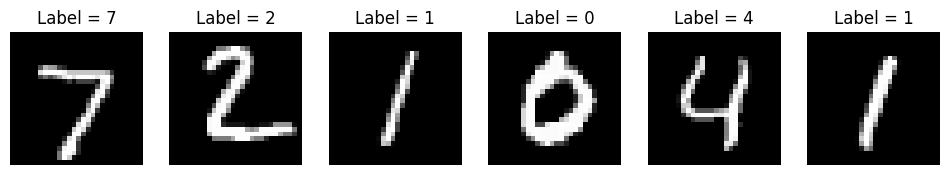


❌ التنبؤات الخاطئة:


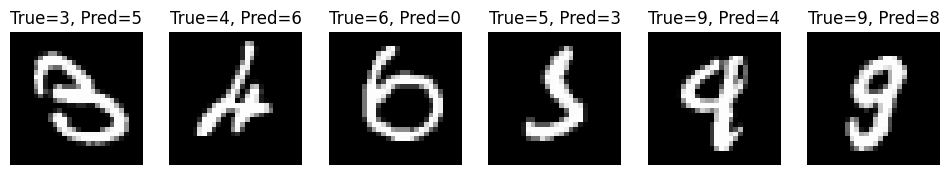

In [10]:
show_predictions(model, test_loader, n=6)